[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/Perceptron_and_LinearSVM.ipynb)

# Perceptron 
The Perceptron algorithm finds the linear decision boundary by considering each example $x^{(n)}, y^{(n)} \in \mathcal{D}$, where $y^{(n)} \in \{-1,+1\}$. 
If $\hat{y}^{(n)} = w^\top x^{(n)}$ has a different sign from $y^{(n)}$ the weights are updated to *increase* $\hat{y}^{(n)} {y}^{(n)}$. The gradient of 
$\hat{y}^{(n)} {y}^{(n)}$ wrt. $w$ is $\frac{\partial}{\partial w} y^{(n)}(w^\top x^{(n)}) = y^{(n)} x^{(n)}$. Therefore, if the example is misclassified
the Perceptron learning algorithm simply updates $w$ using
$$
w^{\{t+1\}} \leftarrow w^{\{t\}} + y^{(n)} x^{(n)}
$$
If the data is linearly separable, the algorithm is guaranteed to converge. 
However, if the data is not linearly separable, this procedure does not converge, and oscillates. Below, we use a `max_iters` to in case the data is not linearly seperable. We also record the update *history* so that we can visualize the learning. To be consistent with previous classification methods, we assume the input labels are in $\{0,1\}$.

In [1]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

In [6]:
class Perceptron:
    
    def __init__(self, add_bias=True, max_iters=10000, record_updates=False):
        self.max_iters = max_iters
        self.add_bias = add_bias
        self.record_updates = record_updates
        if record_updates:
            self.w_hist = [] # records the weight 
            self.n_hist = [] # records the data-point selected
    
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        w = np.zeros(D)                                #initialize the weights
        if self.record_updates:
            w_hist = [w] 
        #y = np.sign(y -.1)                             #to get +1 for class 1 and -1 for class 0
        y = 2*y - 1                                     # converting 0,1 to -1,+1
        t = 0
        change = True                                  #if the weight does not change the algorithm has converged
        while change and t < self.max_iters:
            change = False
            for n in np.random.permutation(N):
                yh = np.sign(np.dot(x[n,:], w))        #predict the output of the training sample
                if yh == y[n]: 
                    continue                           #skip the samples which are correctly classified
                #w = w + (y[n]-yh)*x[n,:]               #update the weights
                w = w + y[n]*x[n,:]
                if self.record_updates:
                    self.w_hist.append(w)
                    self.n_hist.append(n)
                change = True
                t += 1
                if t >= self.max_iters:
                    break
        if change:
            print(f'did not converge after {t} updates')
        else:
            print(f'converged after {t} iterations!')
        self.w = w
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = np.sign(np.dot(self.w, x))
        return (yh + 1)//2                         # converting -/+1 to classes 0,1

Let's apply this to do binary classification with Iris flowers dataset. 
Here, we choose the labels and two features to make the task linearly separable.

In [7]:
from sklearn import datasets
dataset = datasets.load_iris()
x, y = dataset['data'][:,2:], dataset['target']      #slice last two features of Iris dataset
x, y = x[y < 2, :], y[y< 2]                          #slice class 0 and 1

model = Perceptron(record_updates=True)
yh = model.fit(x,y)

converged after 14 iterations!


Let's plot the decision bounday $w^\top x = 0$ using the update history.

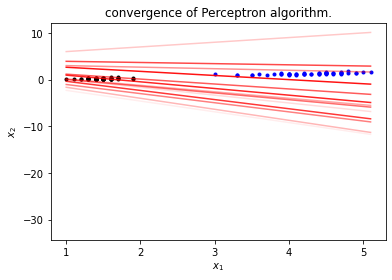

In [8]:
plt.plot(x[y==0,0], x[y==0,1], 'k.' )
plt.plot(x[y==1,0], x[y==1,1], 'b.' )
x_line = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 100)
for t,w in enumerate(model.w_hist):
    coef = -w[0]/w[1]                                     #slope of the decision boundary
    plt.plot(x_line, coef*x_line - w[2]/w[1], 'r-', 
             alpha=t/len(model.w_hist), label=f't={t}')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('convergence of Perceptron algorithm.')
plt.show()

In [5]:
dataset = datasets.load_iris()
x, y = dataset['data'][:,:], dataset['target']
print(x.shape)

(150, 4)


Next let's try an example where the data is not linearly separable.

did not converge after 10000 updates


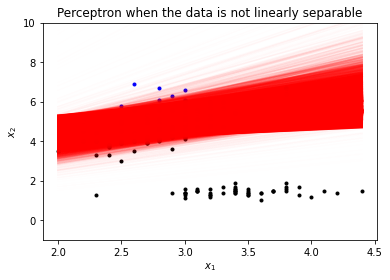

In [9]:
dataset = datasets.load_iris()
x, y = dataset['data'][:,[1,2]], dataset['target']                          #slice feature 1 and 2 of Iris dataset
y =  y > 1
model = Perceptron(record_updates=True)
yh = model.fit(x,y)
plt.plot(x[y==0,0], x[y==0,1], 'k.' )
plt.plot(x[y==1,0], x[y==1,1], 'b.' )
x_line = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 100)
for t,w in enumerate(model.w_hist):
    coef = -w[0]/w[1]
    plt.plot(x_line, coef*x_line - w[2]/w[1], 'r-', alpha=t/len(model.w_hist), label=f't={t}')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.ylim(-1,10)
plt.title('Perceptron when the data is not linearly separable')
plt.show()

# Linear Support Vector Machine

As we saw in lectures, soft margin SVM uses **hinge loss** $L(y, z) = \max(0, 1-yz)$. This is in contrast to the Perceptron's loss function $L(y,z) = \max(0, -yz)$. In addition, while Perceptron uses SGD with a learning rate of $\alpha=1$, we can choose other procedures.

In [10]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        if record_history:
            self.w_history = []
            
    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        t = 1
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            grad = gradient_fn(x, y, w)
            w = w - self.learning_rate * grad
            if self.record_history:
                self.w_history.append(w)
            t += 1
        return w

Below is a simple implementation of Linear SVM, where the only difference with our previous implementation of logistic regression is the choice of loss function and the fact that the input labels are in $\{-1,+1\}$ rather than $\{0,1\}$ (note that in the implementation below, to keep things simple, we are applying the L2 regularization to the intercept as well.)

In [11]:
def cost_fn(x, y, w, lambdaa):
    N, D = x.shape                                      # not really used!
    z = np.dot(x, w)                                    # N
    J = np.mean(np.maximum(0, 1- y*z)) + (lambdaa/2.) * np.linalg.norm(w)**2  #loss of the SVM
    return J

class LinearSVM:    
    def __init__(self, add_bias=True, lambdaa = .01):
        self.add_bias = add_bias
        self.lambdaa = .01
        pass
            
    def fit(self, x, y, optimizer):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        y = 2*y - 1                                     # converting 0,1 to -1,+1
        
        def subgradient(x, y, w):
            N,D = x.shape
            yh = np.dot(x, w)
            violations = np.nonzero(yh*y < 1)[0]                  # get those indexes for which yh*y<1
            grad = -np.dot(x[violations,:].T, y[violations])/N    #compute x^Ty for those indexes and scale it down by N
            grad += self.lambdaa * w                              #add the gradients from the weight regularization term
            return grad

        w0 = np.zeros(D)
        self.w = optimizer.run(subgradient, x, y, w0)
        return self
    
    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = (np.sign(x@self.w) + 1)//2                           #converting -1,+1 to 0,1
        return yh

Let's try again to fit the Iris dataset of previous example this time using linear SVM; this is the setting where the data is not linearly separable.

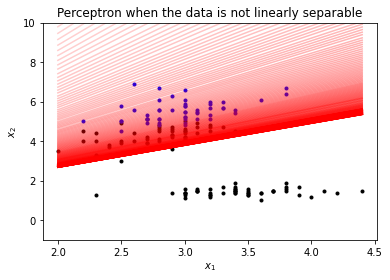

In [12]:
dataset = datasets.load_iris()
x, y = dataset['data'][:,[1,2]], dataset['target']
y =  y > 1
optimizer = GradientDescent(learning_rate=.01, max_iters=300, record_history=True)
model = LinearSVM(lambdaa=.00001)
model.fit(x,y, optimizer)
plt.plot(x[y==0,0], x[y==0,1], 'k.' )
plt.plot(x[y==1,0], x[y==1,1], 'b.' )
x_line = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 100)
for t,w in enumerate(optimizer.w_history):
    coef = -w[0]/w[1]
    plt.plot(x_line, coef*x_line - w[2]/w[1], 'r-', alpha=t/len(optimizer.w_history), label=f't={t}')#, alpha=(t+1)/(len(model.w_hist)+.1))
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.ylim(-1,10)
plt.title('Perceptron when the data is not linearly separable')
plt.show()